# training

输入：xyz<br>
输出：三路压强

数据处理：均值为0且归一化至(-0.5,0.5)

In [21]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import csv
import copy
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [22]:
TRAINING_SET = '../../training_sets/50Dround3.csv' # training set
training_set = '50Dround3'
MODEL_PATH = './models'
TEST_FILE  = '../../test_sets/No3x4.csv' # testing set
FIGURE_PATH = './figures'

Hyperparameters

In [23]:
input_size = 3
hidden_size = 32
output_size = 3
num_epochs = 200
num_layers = 2
learning_rate = 0.001
dropout = 0.2

In [24]:
# reshape the data into a 2D array
def reshape_data(input):
    data = []
    for seq in input:
        for row in seq:
            data.append(row)
    return np.array(data)

# reshape the data back to the original format
def reshape_back(input, format):
    data = []
    index = 0
    for seq in format:
        seq_data = []
        for _ in seq:
            seq_data.append(input[index])
            index += 1
        data.append(seq_data)
    return data

Training

In [25]:
# create an empty list to hold the sequences
sequences = []

# read the CSV file and split it into sequences
with open(TRAINING_SET, newline='') as f:
    reader = csv.reader(f)
    sequence = []
    for row in reader:
        if row[0] == '':  # empty row indicates end of sequence
            sequences.append(sequence)
            sequence = []
        else:
            # convert the row to a list of floats and append to the sequence
            row_float = [float(x) for x in row]
            sequence.append(row_float)
    # append the final sequence
    if sequence:
        sequences.append(sequence)

# print(sequences)
print(len(sequences),len(sequences[0]),len(sequences[0][0]))

12 57 6


In [26]:
# reshape the data into a 2D array
data = reshape_data(sequences)

# normalize the data between -0.5 and 0.5
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
scaled_data = scaler.fit_transform(data)

# reshape the data back to the original format
normalized_data = reshape_back(scaled_data, sequences)

# print(normalized_data)
print(len(normalized_data),len(normalized_data[0]),len(normalized_data[0][0]))

12 57 6


In [27]:
# create a list of tensors, where each tensor contains a batch of data
batched_data = []
for data in normalized_data:
    # create the tensor for this batch
    batch_tensor = torch.tensor(data, dtype=torch.float32)
    
    # add the tensor to the list of batched data
    batched_data.append(batch_tensor)
# print(batched_data)
print(len(batched_data),len(batched_data[0]),len(batched_data[0][0]))

12 57 6


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [29]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout_layer(out)
        out = self.fc(out)
        return out

In [30]:
# Create the model and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
train_losses = []
model.to(device)

LSTMModel(
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [31]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, batch_data in enumerate(batched_data):
        # Separate the inputs and targets
        # inputs = batch_data[:, :, 3:]
        # targets = batch_data[:, :, :3]
        inputs = batch_data[:, 3:]
        targets = batch_data[:, :3]
        inputs = inputs.unsqueeze(0)
        targets = targets.unsqueeze(0)
        # print(inputs)
        # print(inputs.shape, targets.shape)
        
        # Forward pass
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()

        # Print progress
        if (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], Batch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(batched_data), loss.item()))
                
    # Save the loss for plotting
    train_losses.append(running_loss / len(batched_data))

print(f"Max GPU memory allocated: {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")

Epoch [100/100], Batch [1/12], Loss: 0.0032
Epoch [100/100], Batch [2/12], Loss: 0.0041
Epoch [100/100], Batch [3/12], Loss: 0.0057
Epoch [100/100], Batch [4/12], Loss: 0.0049
Epoch [100/100], Batch [5/12], Loss: 0.0029
Epoch [100/100], Batch [6/12], Loss: 0.0035
Epoch [100/100], Batch [7/12], Loss: 0.0032
Epoch [100/100], Batch [8/12], Loss: 0.0025
Epoch [100/100], Batch [9/12], Loss: 0.0049
Epoch [100/100], Batch [10/12], Loss: 0.0037
Epoch [100/100], Batch [11/12], Loss: 0.0038
Epoch [100/100], Batch [12/12], Loss: 0.0031
Max GPU memory allocated: 16.84 MB


In [32]:
MODEL = MODEL_PATH+'/LSTM_'+ str(training_set)+'_'+str(learning_rate)+'_'+str(hidden_size)+'_'+str(num_epochs)+'_'+str(num_layers) + '_' +str(dropout)+'.pth'
torch.save(model.state_dict(), MODEL)

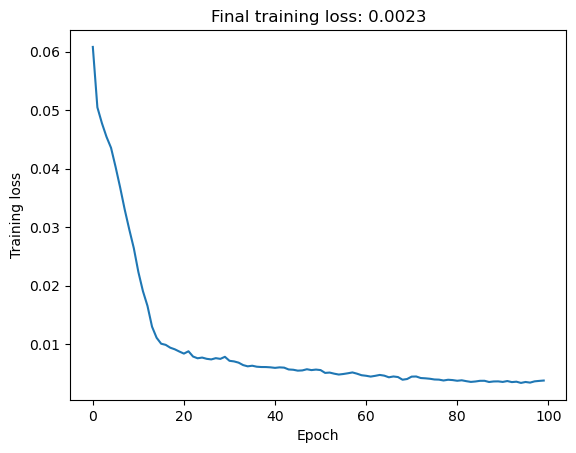

Final training loss: 0.0038


In [33]:
# plot the training loss over time
fig = plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Final training loss: 0.0023')
plt.show()
fig.savefig("output.png", dpi=300, format="png")

# print the final training loss
print('Final training loss: {:.4f}'.format(train_losses[-1]))

Test

In [34]:
# create an empty list to hold the sequences
data_size = 0
sequences_t = []

# read the CSV file and split it into sequences
with open(TEST_FILE, newline='') as f:
    reader = csv.reader(f)
    sequence = []
    for row in reader:
        if row[0] == '':  # empty row indicates end of sequence
            sequences_t.append(sequence)
            sequence = []
        else:
            # convert the row to a list of floats and append to the sequence
            row_float = [float(x) for x in row]
            sequence.append(row_float)
            data_size += 1
    # append the final sequence
    if sequence:
        sequences_t.append(sequence)

print(data_size)
print(len(sequences_t),len(sequences_t[0]),len(sequences_t[0][0]))

184
4 51 6


In [35]:
# reshape the data into a 2D array
data_t = reshape_data(sequences_t)

# normalize the data between -0.5 and 0.5
scaled_data_t = scaler.transform(data_t)

# reshape the data back to the original format
normalized_data_t = reshape_back(scaled_data_t, sequences_t)

# print(normalized_data_t)
print(len(normalized_data_t),len(normalized_data_t[0]),len(normalized_data_t[0][0]))

4 51 6


In [36]:
# create a list of tensors, where each tensor contains a batch of data
batched_data_t = []
for data in normalized_data_t:
    # create the tensor for this batch
    batch_tensor = torch.tensor(data, dtype=torch.float32)
    
    # add the tensor to the list of batched data
    batched_data_t.append(batch_tensor)

# print(batched_data_t)
print(len(batched_data_t),len(batched_data_t[0]),len(batched_data_t[0][0]))

4 51 6


In [37]:
# set the model to evaluation mode
model.eval()

test_loss = 0.0

# Create empty lists to store the  predicted values
predicted_values = []

# iterate over the test data batches
for batch_data in batched_data_t:
    # extract the input and target sequences
    inputs = batch_data[:, 3:]
    targets = batch_data[:, :3]
    inputs = inputs.unsqueeze(0)
    targets = targets.unsqueeze(0)
    
    # pass the inputs through the model to get the predictions
    with torch.no_grad():
        outputs = model(inputs.to(device))
    
    # Append the predicted values to the lists
    predicted_values.append(np.squeeze(outputs.cpu().numpy(), axis=0))
  
    # calculate the loss between the predictions and targets
    loss = criterion(outputs, targets.to(device))
    
    # accumulate the loss for the test set
    test_loss += loss.item() * inputs.size(0)

# calculate the average test loss
test_loss /= len(batched_data_t)

# print the test loss
print("Test Loss: {:.6f}".format(test_loss))

print(len(predicted_values),len(predicted_values[0]),len(predicted_values[0][0]))

Test Loss: 0.132087
4 51 3


In [38]:
# reshape the real data into a 2D array
data_r = reshape_data(sequences_t)

# reshape the data into a 2D array
data_p = np.zeros(data_r.shape)
data_p[:, :3] = reshape_data(predicted_values)

# De-normalize the data between -0.5 and 0.5
normalized_data_p = scaler.inverse_transform(data_p)

print(len(data_r),len(data_r[0]))

184 6


In [39]:
max_err = np.max(np.abs(normalized_data_p[:, :3]-data_r[:, :3]))
mean_p1_err = np.mean(np.abs(normalized_data_p[:,0]-data_r[:,0]))
mean_p2_err = np.mean(np.abs(normalized_data_p[:,1]-data_r[:,1]))
mean_p3_err = np.mean(np.abs(normalized_data_p[:,2]-data_r[:,2]))
err = np.zeros((data_size,1))
for i in range(data_size):
    err[i] = np.mean(np.abs(normalized_data_p[i,:3]-data_r[i,:3]))

print('maximum pressure error',max_err)
print('p1 mean error:',round(mean_p1_err,2),'kpa')
print('p2 mean error:',round(mean_p2_err,2),'kpa')
print('p3 mean error:',round(mean_p3_err,2),'kpa')
print('mean error per way:',round(np.mean(err),2),'kpa') 

maximum pressure error 20.23027909696102
p1 mean error: 3.62 kpa
p2 mean error: 5.23 kpa
p3 mean error: 3.42 kpa
mean error per way: 4.09 kpa


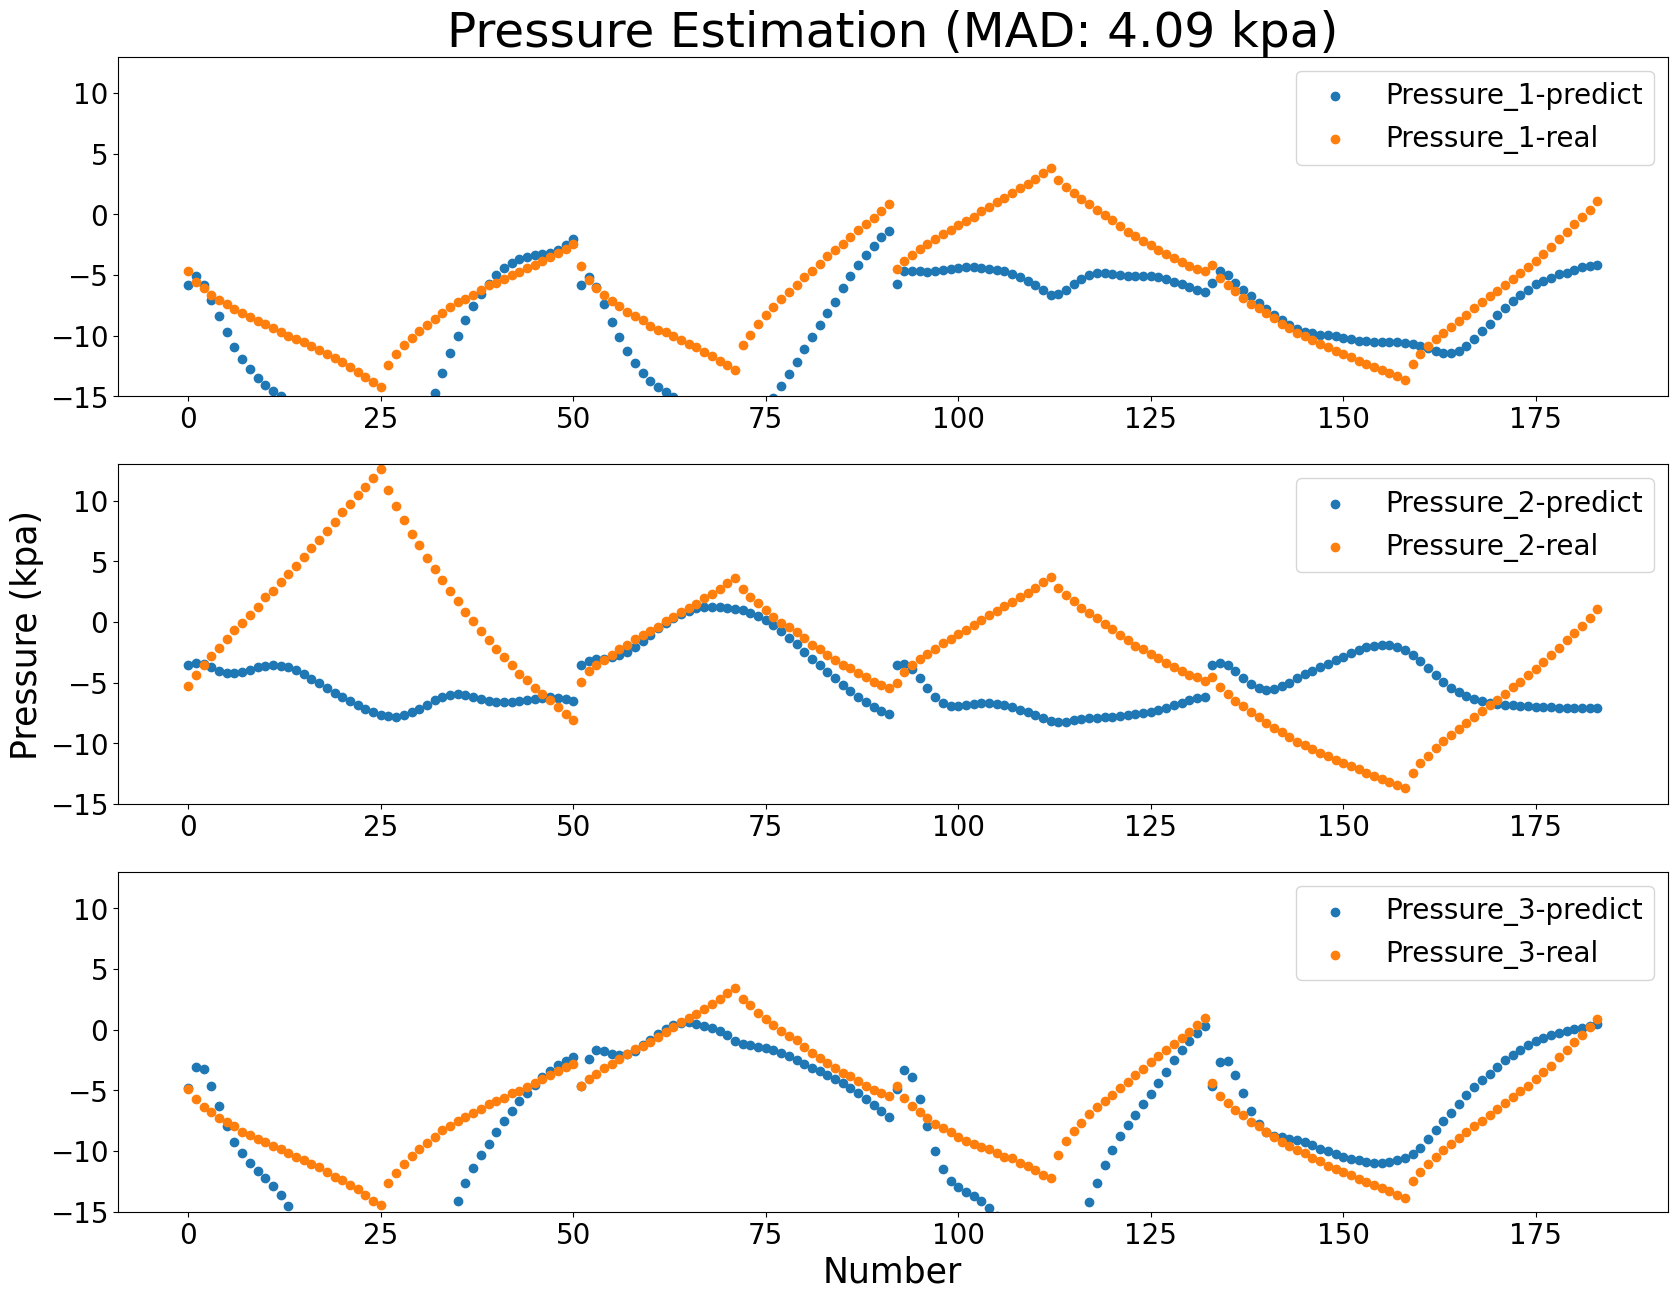

In [40]:
fig = plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.scatter(np.arange(data_size),normalized_data_p[:, 0],label='Pressure_1-predict')
plt.scatter(np.arange(data_size),data_r[:, 0],label='Pressure_1-real')
plt.title('Pressure Estimation (MAD: '+str(round(np.mean(err),2))+' kpa)',fontsize=35)
plt.ylim(-15, 13)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.subplot(3,1,2)
plt.scatter(np.arange(data_size),normalized_data_p[:, 1],label='Pressure_2-predict')
plt.scatter(np.arange(data_size),data_r[:, 1],label='Pressure_2-real')
plt.ylim(-15, 13)
plt.tick_params(labelsize=20)
plt.ylabel('Pressure (kpa)',fontsize=25)
plt.legend(fontsize=20)
plt.subplot(3,1,3)
plt.scatter(np.arange(data_size),normalized_data_p[:, 2],label='Pressure_3-predict')
plt.scatter(np.arange(data_size),data_r[:, 2],label='Pressure_3-real')
plt.ylim(-15, 13)
plt.tick_params(labelsize=20)
plt.xlabel('Number',fontsize=25)
plt.legend(fontsize=20)

# save the figure
# fig.savefig(FIGURE_PATH+'/LSTM_'+ str(training_set)+'_'+str(learning_rate)+'_'+str(hidden_size)+'_'+str(num_epochs)+'_'+str(num_layers)+'.png')